# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos epsilon-greedy en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Author: Luis Daniel Hernández Molinero
    Email: ldaniel@um.es
    Date: 2025/01/29

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


In [1]:
#@title Copiar el repositorio.

!git clone https://github.com/ermaury/k_brazos_AM_DE_JP.git
!cd k_brazos_AM_DE_JP/

Cloning into 'k_brazos_AM_DE_JP'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 69 (delta 33), reused 54 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 1.41 MiB | 10.33 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [2]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_AM_DE_JP')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, GradientBandit
from arms import ArmNormal, ArmBernouilli, ArmBinomial, ArmBeta, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret, plot_arm_statistics


semilla = 42

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_AM_DE_JP']


## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [3]:
def run_experiment(bandit, algorithms: List, steps: int, runs: int):
    """
    Ejecuta experimentos con múltiples algoritmos sobre un bandit dado.

    :param bandit: Instancia de la clase Bandit.
    :param algorithms: Lista de instancias de algoritmos a evaluar.
    :param steps: Número de pasos de tiempo a simular.
    :param runs: Número de ejecuciones para promediar los resultados.

    :return: rewards, optimal_selections, regret_accumulated, arm_stats -
             Matrices con recompensas, selecciones óptimas, regret acumulado y estadísticas de brazos.
    """

    optimal_arm = bandit.optimal_arm  # Índice del brazo óptimo
    optimal_reward = bandit.expected_rewards[optimal_arm]  # Recompensa esperada del brazo óptimo
    num_arms = len(bandit.arms)  # Número total de brazos

    rewards = np.zeros((len(algorithms), steps))  # Matriz para recompensas promedio
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para selecciones óptimas
    regrets = np.zeros((len(algorithms), steps))  # Matriz para regret acumulado

    # Inicializar estadísticas de cada brazo por algoritmo
    arm_stats = [
        {
            'total_rewards': np.zeros(num_arms),  # Suma de recompensas por brazo
            'selections': np.zeros(num_arms),    # Veces que se seleccionó cada brazo
            'optimal_arm': optimal_arm,          # Guardar cuál es el brazo óptimo
        }
        for _ in range(len(algorithms))
    ]

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)  # Nueva instancia del bandit

        # Reiniciar los algoritmos
        for algo in algorithms:
            algo.reset()

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()  # Seleccionar un brazo
                reward = current_bandit.pull_arm(chosen_arm)  # Obtener recompensa
                algo.update(chosen_arm, reward)  # Actualizar valores estimados

                rewards[idx, step] += reward  # Acumular recompensa

                # Si el brazo elegido es el óptimo, incrementar el contador
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Cálculo del regret instantáneo
                regret = optimal_reward - reward
                regrets[idx, step] += regret

                # Guardar estadísticas del brazo seleccionado
                arm_stats[idx]['total_rewards'][chosen_arm] += reward
                arm_stats[idx]['selections'][chosen_arm] += 1

    # Promediar los valores sobre el número de ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje
    regrets /= runs  # Promediar regret acumulado

    # Calcular promedio de recompensas por brazo
    for idx in range(len(algorithms)):
        # Evitar divisiones por cero (si un brazo no fue seleccionado)
        mask = arm_stats[idx]['selections'] > 0
        arm_stats[idx]['avg_rewards'] = np.zeros(num_arms)
        arm_stats[idx]['avg_rewards'][mask] = arm_stats[idx]['total_rewards'][mask] / arm_stats[idx]['selections'][mask]

    return rewards, optimal_selections, regrets, arm_stats

## Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [4]:
# Parámetros del experimento
np.random.seed(semilla)
k = 10          # Número de brazos
steps = 1000    # Pasos de tiempo
runs = 500      # Número de ejecuciones

# Crear el bandit con brazos de distribución normal
bandit = Bandit(arms=ArmNormal.generate_arms(k))
print(bandit)
optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar
algorithms = [
    GradientBandit(k=k, alpha=0.1),
    GradientBandit(k=k, alpha=0.05),
    GradientBandit(k=k, alpha=0.01)
]

rewards, optimal_selections, regrets, arm_stats = run_experiment(bandit, algorithms, steps, runs)


Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


## Visualización de los resultados

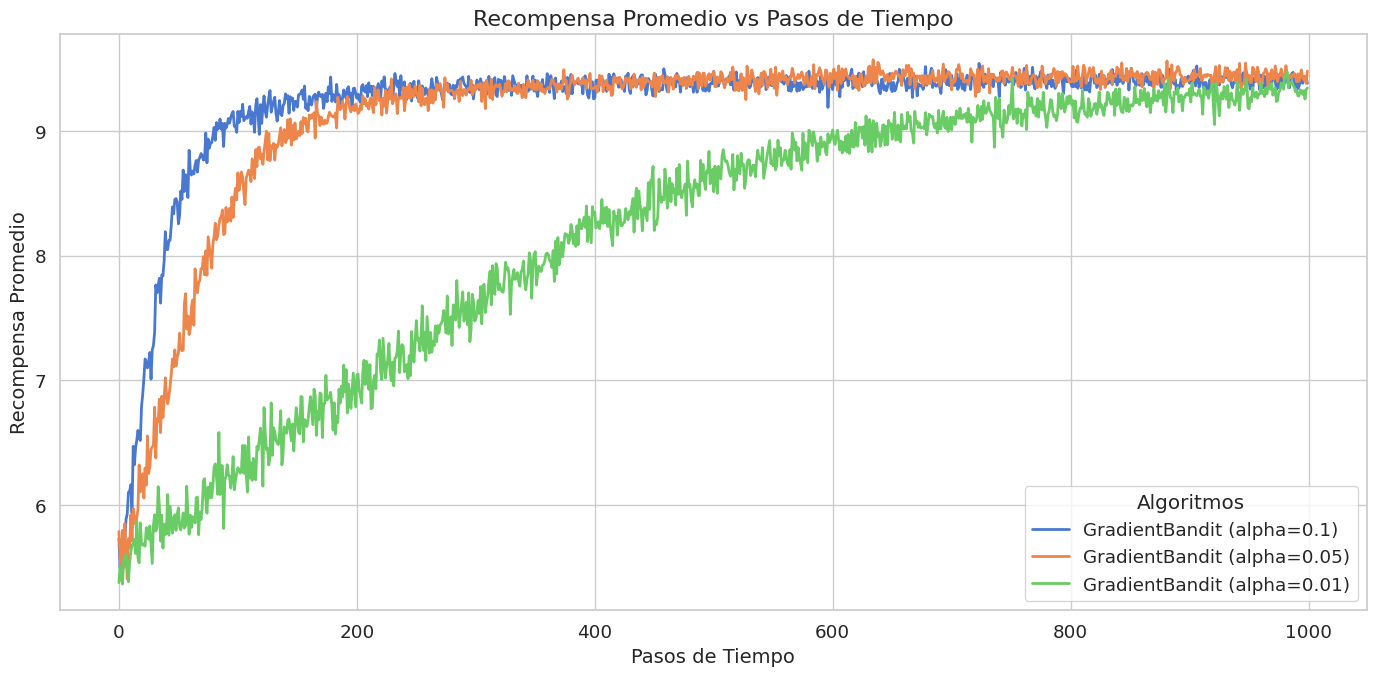

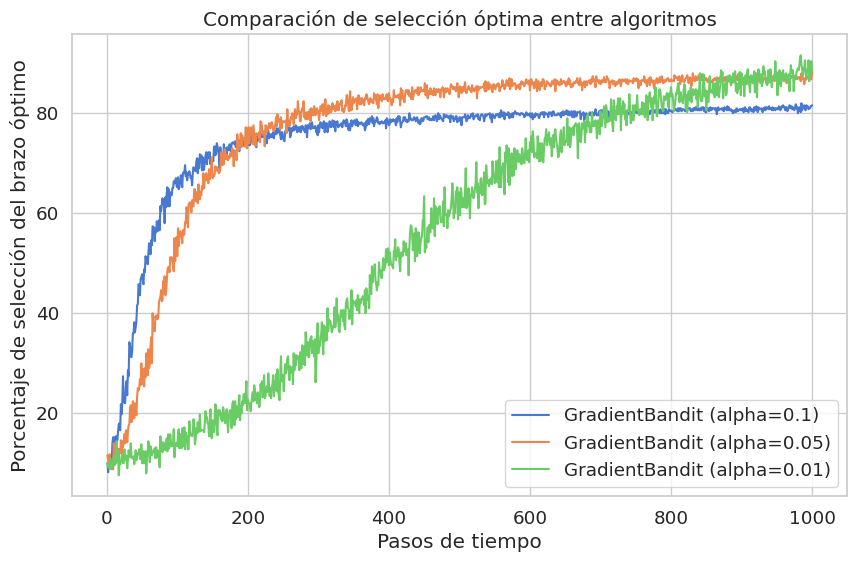

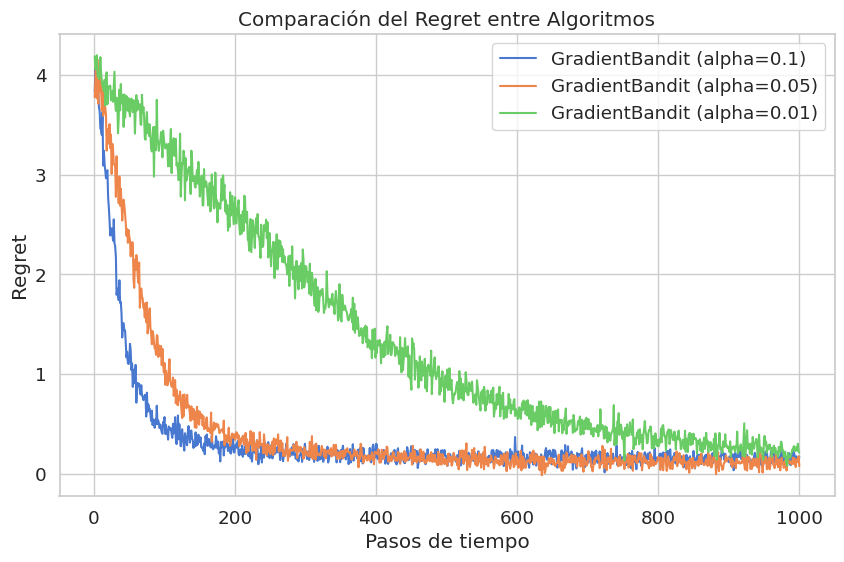

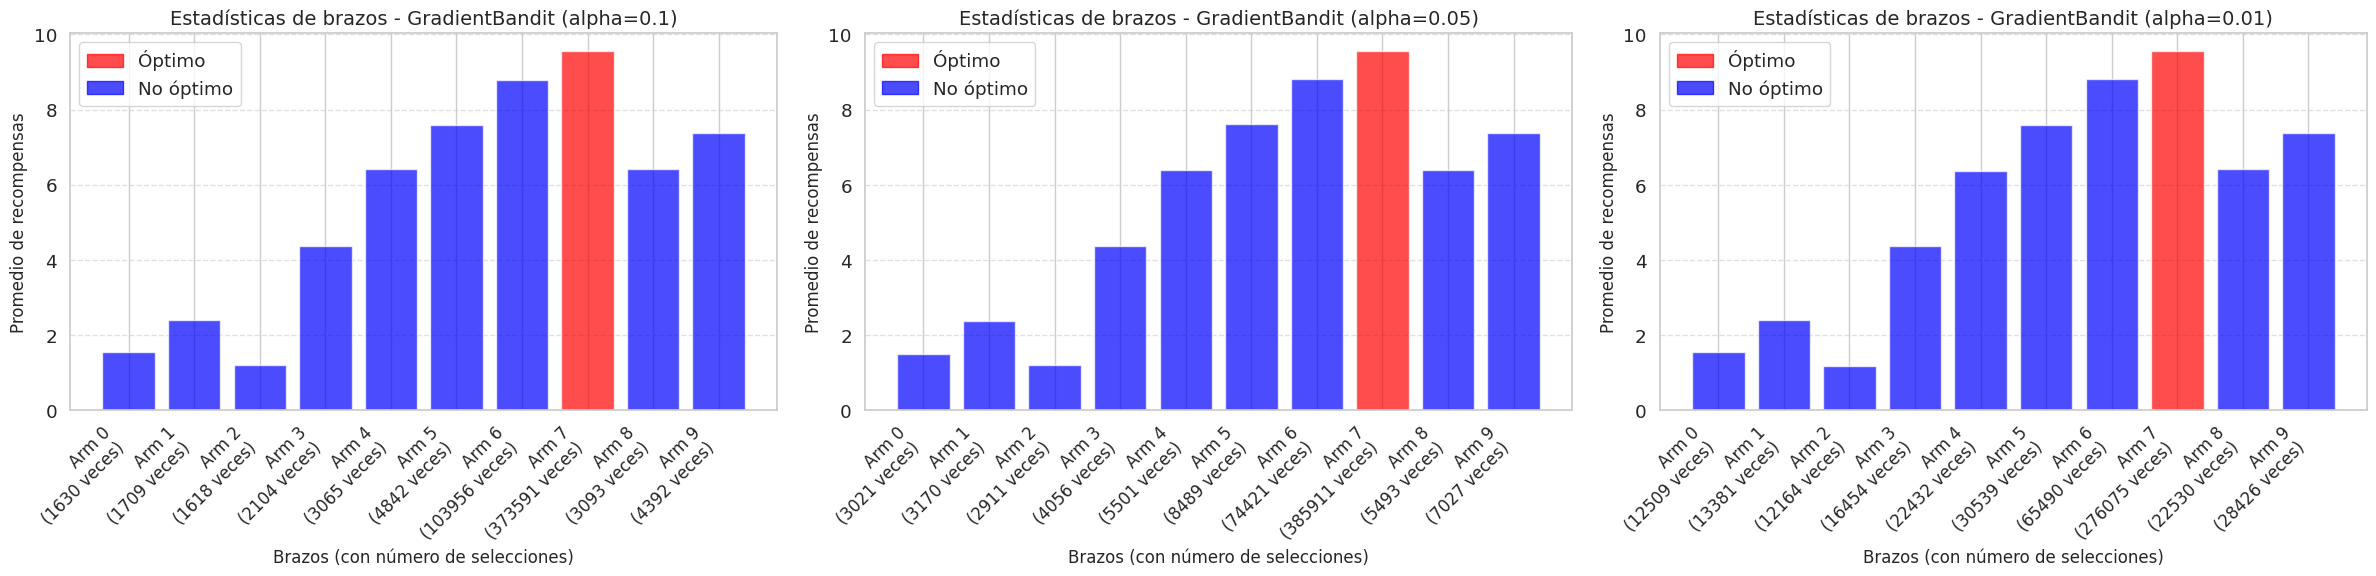

In [6]:
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)
plot_optimal_selections(steps, optimal_selections, algorithms)
plot_regret(steps, regrets, algorithms)
plot_arm_statistics(arm_stats, algorithms)

### Análisis detallado de la imagen

La imagen muestra un gráfico de líneas titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Crecimiento de la recompensa promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1.
   - La línea **azul (ε=0)** se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.

---





## Conclusiones

Hemos estudiado un  **experimento de toma de decisiones secuenciales**, modelado con un **Multi-Armed Bandit (MAB)**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **ε-Greedy** equilibra la exploración y la explotación:
- **Explotación (ε=0)**: Siempre elige la mejor opción conocida, pero si inicialmente se selecciona un brazo subóptimo, nunca descubrirá otras opciones más rentables.
- **Exploración (ε>0)**: Introduce aleatoriedad en la selección de acciones para descubrir nuevas opciones potencialmente mejores.

El gráfico confirma este comportamiento:
- **ε=0.1 (verde)** obtiene la mejor recompensa promedio a lo largo del tiempo porque explora lo suficiente como para encontrar rápidamente el mejor brazo.
- **ε=0.01 (naranja)** explora menos, por lo que tarda más en converger a una recompensa alta.
- **ε=0 (azul)** no explora en absoluto y queda atrapado en una recompensa subóptima.

#### **2. Convergencia de los algoritmos**
Los algoritmos con mayor exploración (ε=0.1) alcanzan una recompensa alta más rápido. Esto se debe a que:
- Al principio, el algoritmo **no tiene información suficiente** sobre cuál es el mejor brazo.
- Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
- Un **balance entre exploración y explotación** es clave para maximizar la recompensa a largo plazo.


#### **3. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **ε=0.1** es más efectiva para encontrar la mejor opción rápidamente.
- **La falta de exploración (ε=0)** lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.

En conclusión, **el gráfico muestra cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo en un entorno de aprendizaje por refuerzo**. 🚀